In [ ]:
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D
# import tsensor
# import numpy as np

# sentences = [
#     'The quick brown fox jumps over the lazy dog'
# ]
# tokenizer = Tokenizer()

# tokenizer.fit_on_texts(sentences)

# tokenizer.word_index

# train_sequence = tokenizer.texts_to_sequences(sentences)
# train_sequence = np.array(train_sequence)
# print(train_sequence)

# embedding = Embedding(input_dim=len(train_sequence[0]), output_dim=128)

# train_sample = embedding(train_sequence)

# print(train_sequence.shape)
# print(train_sample.shape)

# with tsensor.explain(fontname='monospace', dimfontname='monospace'):
#     train_sample = embedding(train_sequence)

# with tsensor.explain(fontname='monospace', dimfontname='monospace'):
#     z = GlobalAveragePooling1D()(train_sample)

# test_corpus = [
#     'The quick brown fox jumps over the lazy dog.',
#     'The quick brown fox.',
#     'The lazy dog.',
#     'The dog.',
#     'Dog and the fox.',
#     'Hello, world!'
# ]

# encoded_sentences = tokenizer.texts_to_sequences(test_corpus)
# for sentence, encoded_sentence in zip(test_corpus, encoded_sentences):
#     print(sentence, encoded_sentence)

# MAX_SEQUENCE_LENGTH = max([len(s) for s in encoded_sentences])
# MAX_SEQUENCE_LENGTH

# X = pad_sequences(encoded_sentences, maxlen=MAX_SEQUENCE_LENGTH)
# X

# ## Embedding Layer

# X.shape

# X_embedded = embedding(X)

# X_embedded.shape

# with tsensor.explain(fontname='monospace', dimfontname='monospace'):
#     x_em = embedding(X)

# # this is like creating a "sentence vector" from "word vectors"
# with tsensor.explain(fontname='monospace', dimfontname='monospace'):
#     z = GlobalAveragePooling1D()(x_em)

In [3]:
import numpy as np
from gensim.models import KeyedVectors

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import utils

In [4]:
train_ds = text_dataset_from_directory('./Distributional Semantics/data/aclImdb/train')

Found 25001 files belonging to 2 classes.


2025-02-19 15:36:18.548412: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-02-19 15:36:18.548460: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-19 15:36:18.548468: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1739959578.549046  263308 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1739959578.549538  263308 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
test_ds = text_dataset_from_directory('./Distributional Semantics/data/aclImdb/test')

Found 25000 files belonging to 2 classes.


In [7]:
df_train = pd.DataFrame(train_ds.unbatch().as_numpy_iterator(), columns=['text', 'label'])
df_test = pd.DataFrame(test_ds.unbatch().as_numpy_iterator(), columns= ['text', 'label'])
_, xts = train_test_split(df_test, stratify=df_test['label'], test_size=0.25)

2025-02-19 15:36:59.239540: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-19 15:37:01.735854: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
df_train['text'] = df_train['text'].apply(lambda x : x.decode())
xts['text'] = xts['text'].apply(lambda x: x.decode())

In [9]:
pd.options.display.max_colwidth=200
df_train.sample(n=5)

,text,label
756,"More wide-eyed, hysterical 50s hyper-cheerfulness that gives new meaning to anti-social, pathological behaviour. Danza and Grayson will leave you begging for mercy.<br /><br />It's a shame that al...",0
4515,"After reading the other tepid reviews and comments, I felt I had to come to bat for this movie.<br /><br />Roeg's films tend to have little to do with one another, and expecting this one to be lik...",1
24172,I was very excited to see that they had made a movie out of my favorite book ever. I didn't realize it was Disney until it was too late. I was appalled by the many omissions of crucial parts of th...,0
20807,"This is a great movie from the lost age of reactionary made-for-television drama. My all-time favourite actor, Robert Culp skillfully plots a trajectory through uptight liberal fairmindedness and ...",1
1365,"Spinal Tap was funny because if you knew a little about heavy metal, you saw in-jokes all over the place. If you know anything about porn, this mock documentary will leave you cold. Everything in ...",0


In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['text'].to_list())

train_sequences = tokenizer.texts_to_sequences(df_train['text'].to_list())
test_sequences = tokenizer.texts_to_sequences(xts['text'].to_list())

In [11]:
print(f'unique words: {len(tokenizer.word_index)}')

unique words: 88582


In [30]:
print(df_train.iloc[0,0])
print(train_sequences[0])
print([tokenizer.index_word[k] for k in train_sequences[0]])

This was the first sequel I'd seen (apart from Return of Jafar) and I honestly thought before watching it that it would be close to the original. I was horribly disappointed.<br /><br />The storyline was, basically, the first script with a few extra characters and the situation turned around. Ariel and Eric have a daughter, Melody who isn't satisfied with life on land. She wants to become a mermaid. However, Ariel has kept her past from her daughter because she wants to protect her-and when Melody finds out she's upset and angry. And she then decides to run away, and she becomes a mermaid. So she's happy swimming around, and Ariel sets out to find her-as a mermaid.<br /><br />The story doesn't sound too bad written down, but the clichés and repeats of situations from the first movie are just too obvious. And adding the fact that Melody is, overall, extremely annoying, and the movie becomes almost unbearable.<br /><br />There's also a whole load of other new characters-Tip and Dash bein

In [12]:
# now we have train_sequences and test_sequences which are arrays of token-list
# we need to find the sentence in both train and test sequences which has the highest number of tokens

train_max = max([len(sequence) for sequence in train_sequences])
test_max = max([len(sequence) for sequence in test_sequences])
MAX_SEQUENCE_LENGTH = max(train_max, test_max)
MAX_SEQUENCE_LENGTH

2493

In [13]:
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [14]:
print(train_data.shape)
print(test_data.shape)

(25001, 2493)
(6250, 2493)


In [15]:
print([tokenizer.index_word.get(item, '<PAD>') for item in train_data[0]])

['<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 

In [16]:
vocabulary = KeyedVectors.load('./Distributional Semantics/codes/wiki-countries.w2v')

In [17]:
embedding = utils.make_embedding_layer(vocabulary, tokenizer, MAX_SEQUENCE_LENGTH)

/Users/suyashkumarsingh/.pyenv/versions/tensorflow/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [18]:
countries_wiki_model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    embedding,
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
countries_wiki_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [19]:
countries_wiki_history = countries_wiki_model.fit(
    train_data, df_train['label'].values,
    validation_data=(test_data, xts['label'].values),
    batch_size=64, epochs=30
)

Epoch 1/30


2025-02-19 15:37:36.599302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6101 - loss: 0.6533 - val_accuracy: 0.6973 - val_loss: 0.5885
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7133 - loss: 0.5739 - val_accuracy: 0.7106 - val_loss: 0.5712
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7201 - loss: 0.5652 - val_accuracy: 0.7206 - val_loss: 0.5705
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7226 - loss: 0.5613 - val_accuracy: 0.7214 - val_loss: 0.5636
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7247 - loss: 0.5591 - val_accuracy: 0.7163 - val_loss: 0.5675
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7298 - loss: 0.5552 - val_accuracy: 0.7195 - val_loss: 0.5664
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7290 - loss: 0.5575 - val_accuracy: 0.7176 - val_loss: 0.5691
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7185 - loss: 0.5672 - val_accuracy: 0.725

In [20]:
vocabulary_glove = KeyedVectors.load_word2vec_format('glove.6B/glove.6B.300d.txt', binary=False, no_header=True)

In [21]:
embedding = utils.make_embedding_layer(vocabulary_glove, tokenizer, MAX_SEQUENCE_LENGTH)

In [22]:
glove_wiki_model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    embedding,
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
glove_wiki_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [23]:
glove_wiki_history = glove_wiki_model.fit(
    train_data, df_train['label'].values,
    validation_data=(test_data, xts['label'].values),
    batch_size=64, epochs=30
)

Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6225 - loss: 0.6422 - val_accuracy: 0.7475 - val_loss: 0.5355
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7973 - loss: 0.4714 - val_accuracy: 0.8059 - val_loss: 0.4645
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8146 - loss: 0.4340 - val_accuracy: 0.8219 - val_loss: 0.4308
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8249 - loss: 0.4165 - val_accuracy: 0.8232 - val_loss: 0.4321
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8277 - loss: 0.4118 - val_accuracy: 0.8283 - val_loss: 0.4235
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8282 - loss: 0.4040 - val_accuracy: 0.8142 - val_loss: 0.4368
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8284 - loss: 0.4080 - val_accuracy: 0.8282 - val_loss: 0.4149
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8272 - loss: 0.4136 - val_accu

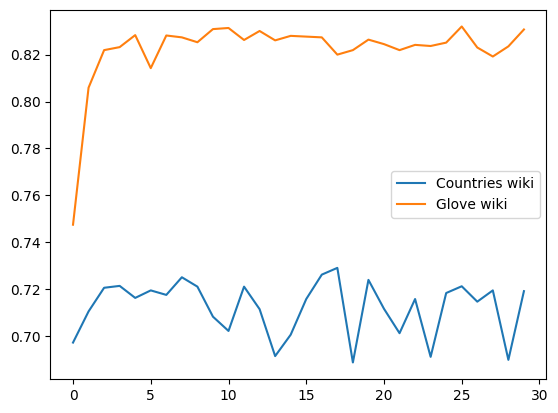

In [24]:
plt.plot(countries_wiki_history.history['val_accuracy'], label='Countries wiki')
plt.plot(glove_wiki_history.history['val_accuracy'], label='Glove wiki')
plt.legend()
plt.show()